In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging

import holoviews as hv
import hvplot.polars
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy.signal as signal
from icecream import ic
from numba import njit
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.transforming import (
    map_trials,
)
from src.log_config import configure_logging
from src.plots.utils import prepare_multiline_hvplot

logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])
configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "param", "numba"],
)


pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [3]:
db = DatabaseManager()

In [4]:
with db:
    df = db.get_table("Raw_Pupil")
df

trial_id,trial_number,participant_id,rownumber,timestamp,pupil_l,pupil_r,pupil_l_distance,pupil_r_distance
u16,u8,u8,u32,f64,f64,f64,f64,f64
1,1,1,17631,294198.9762,5.73628,6.245389,633.132751,633.648865
1,1,1,17632,294215.605,5.726105,6.240875,633.103638,633.604187
1,1,1,17633,294232.4178,5.710716,6.233272,633.02179,633.481628
1,1,1,17634,294248.9778,5.703059,6.225731,632.948242,633.338501
1,1,1,17635,294265.7282,5.693711,6.221862,632.95343,633.235779
1,1,1,17636,294282.4034,5.679268,6.218964,632.877136,633.106323
…,…,…,…,…,…,…,…,…
332,12,28,166436,2.7770e6,4.150071,4.038912,604.708679,603.684204
332,12,28,166437,2.7771e6,4.143601,4.031703,604.708679,603.684204


In [5]:
df = df.filter(col("trial_id") == 1)
df.hvplot(x="timestamp", y="pupil_r")

:Curve   [timestamp]   (pupil_r)

In [8]:
from src.features.filtering import filter_butterworth, filter_butterworth_ba, filter_butterworth_zi

data = filter_butterworth(
    df.get_column("pupil_r"), 60, lowcut=0, highcut=0.2, order=2
)
series = pl.Series("pupil_r_filtered", data)
df = df.with_columns(series)
df.hvplot(x="timestamp", y=["pupil_r", "pupil_r_filtered"])

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

In [65]:
df.height

10789

In [66]:
# 1 Preparing the raw data

In [67]:
# 1.1 Filtering out the invalid data

df = df.filter(col("pupil_r") != -1, col("pupil_l") != -1)

In [68]:
# 2 Filtering the raw data

In [11]:
d = df["pupil_r"]
t= df["timestamp"]
# Calculate first differences
d_diff = np.diff(d)  # d[i+1] - d[i]
t_diff = np.diff(t)

# Calculate rates of change
rates = np.abs(d_diff / t_diff)

# Calculate max of rates[i-1] and rates[i] for each valid i
d_prime = np.maximum(rates[:-1], rates[1:])

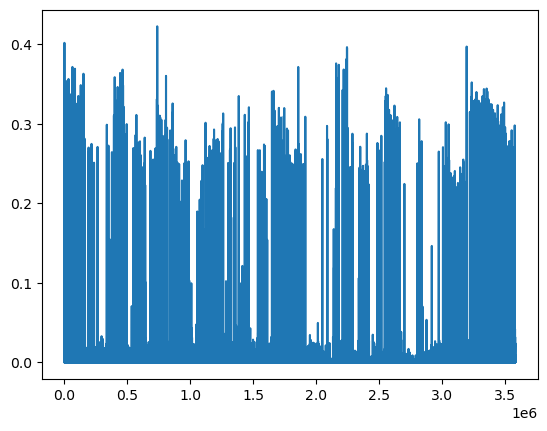

In [18]:
plt.plot(rates)

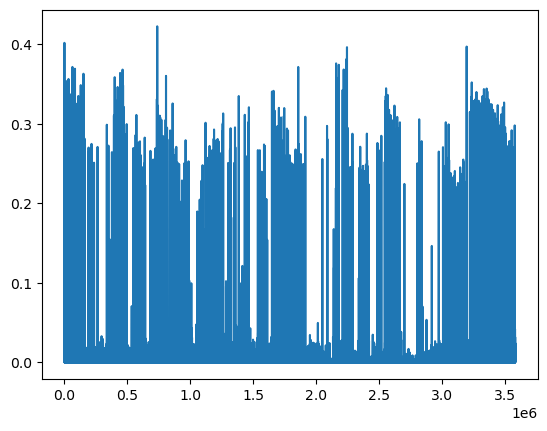

In [19]:
plt.plot(d_prime)


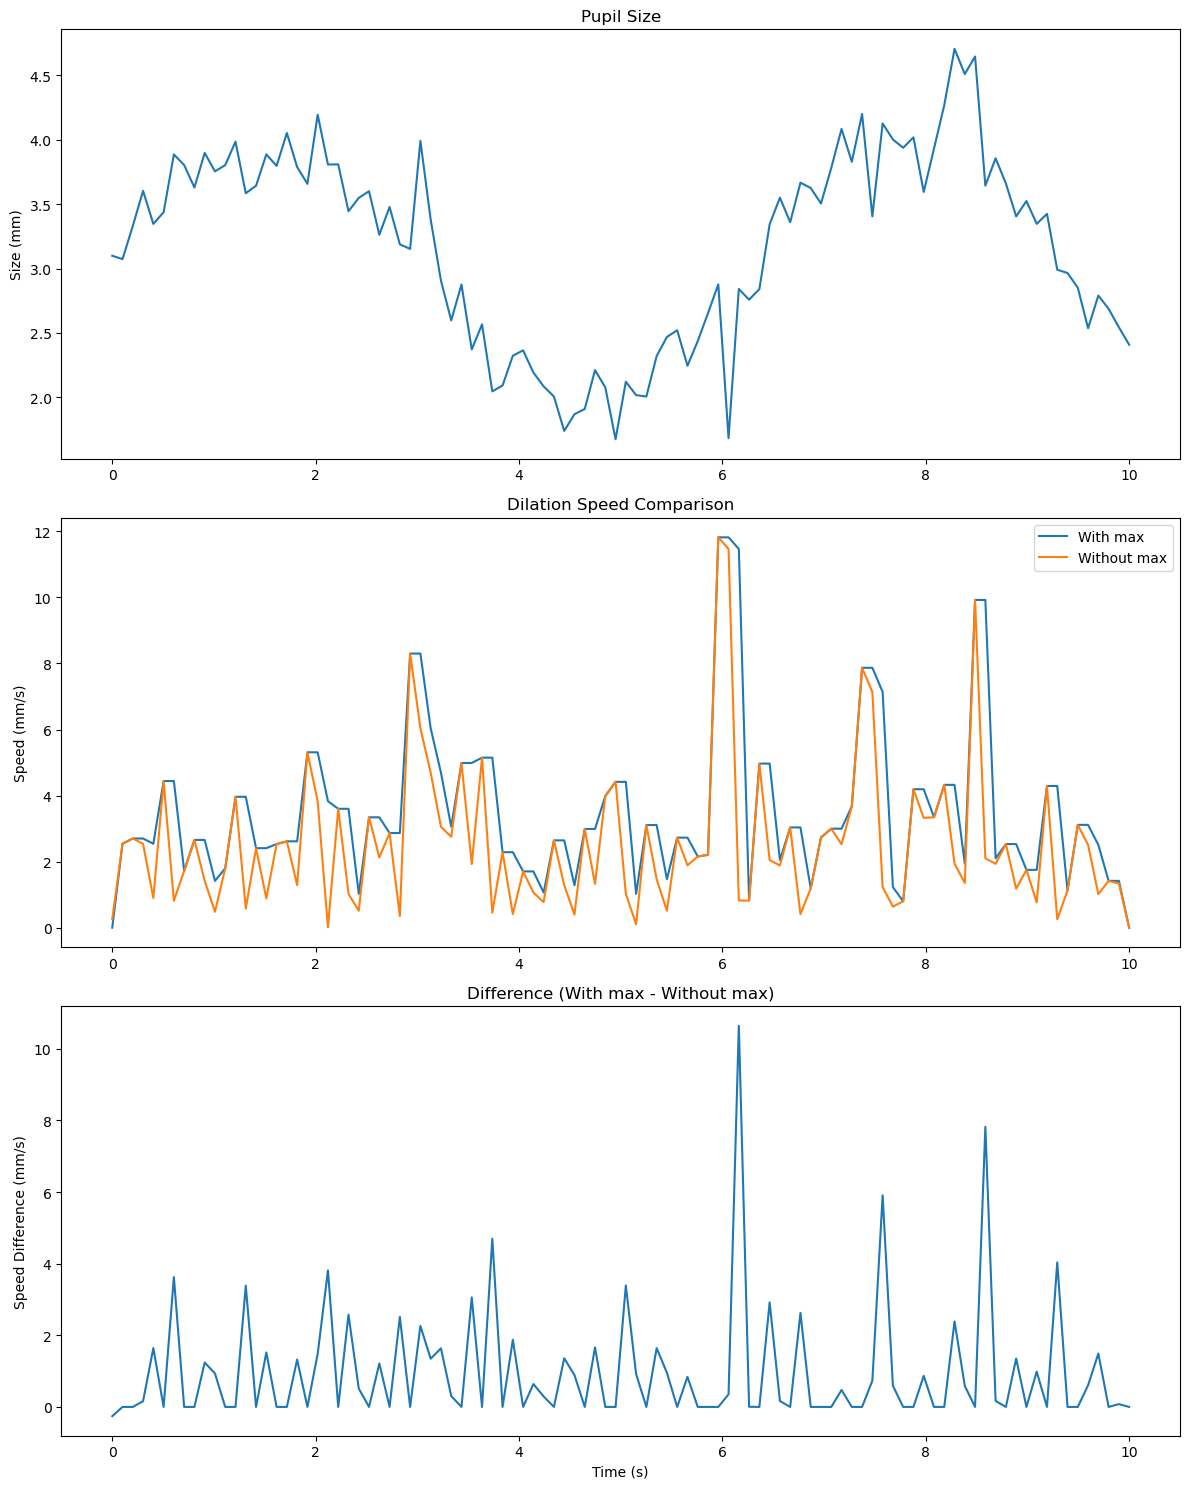

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
np.random.seed(42)
t = np.linspace(0, 10, 100)  # 100 time points over 10 seconds
pupil_size = 3 + np.sin(t) + 0.2 * np.random.randn(100)  # Base signal with some noise

# Add some artifacts
pupil_size[30] += 1  # Sudden increase
pupil_size[60] -= 1  # Sudden decrease
pupil_size[80:85] += np.linspace(0, 1, 5)  # Gradual artifact

# Calculate dilation speed with max
def dilation_speed_with_max(sizes, times):
    speeds = np.zeros_like(sizes)
    for i in range(1, len(sizes)-1):
        forward = abs((sizes[i+1] - sizes[i]) / (times[i+1] - times[i]))
        backward = abs((sizes[i] - sizes[i-1]) / (times[i] - times[i-1]))
        speeds[i] = max(forward, backward)
    return speeds

# Calculate dilation speed without max (using only forward difference)
def dilation_speed_without_max(sizes, times):
    speeds = np.zeros_like(sizes)
    for i in range(len(sizes)-1):
        speeds[i] = abs((sizes[i+1] - sizes[i]) / (times[i+1] - times[i]))
    return speeds

# Calculate both versions of dilation speed
speed_with_max = dilation_speed_with_max(pupil_size, t)
speed_without_max = dilation_speed_without_max(pupil_size, t)

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

ax1.plot(t, pupil_size)
ax1.set_title('Pupil Size')
ax1.set_ylabel('Size (mm)')

ax2.plot(t, speed_with_max, label='With max')
ax2.plot(t, speed_without_max, label='Without max')
ax2.set_title('Dilation Speed Comparison')
ax2.set_ylabel('Speed (mm/s)')
ax2.legend()

ax3.plot(t, speed_with_max - speed_without_max)
ax3.set_title('Difference (With max - Without max)')
ax3.set_ylabel('Speed Difference (mm/s)')
ax3.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

In [69]:
# 2.1 Dilation speed outliers and edge artifacts


def calculate_d_prime(d, t):
    """
    Calculate d' based on the given equation:

    d' = max(|d[i] - d[i-1] / t[i] - t[i-1]|, |d[i+1] - d[i] / t[i+1] - t[i]|)

    Parameters:
    d : numpy.ndarray
        Array of d values
    t : numpy.ndarray
        Array of t values (same length as d)

    Returns:
    numpy.ndarray
        Array of d' values (length will be len(d) - 2)
    """

    # Calculate first differences
    d_diff = np.diff(d)  # d[i+1] - d[i]
    t_diff = np.diff(t)

    # Calculate rates of change
    rates = np.abs(d_diff / t_diff)

    # Calculate max of rates[i-1] and rates[i] for each valid i
    d_prime = np.maximum(rates[:-1], rates[1:])

    return d_prime


d_prime_r = calculate_d_prime(df["pupil_r"], df["timestamp"])
d_prime_r

array([0.00124178, 0.00112151, 0.00123349, ..., 0.00024595, 0.00021165,
       0.00051108])

In [76]:
def calculate_mad_and_threshold(d_prime, n):
    """
    Calculate the Median Absolute Deviation (MAD) and the threshold for outlier detection.

    Parameters:
    d_prime (numpy.ndarray): The dilation speed series d'.
    n (float): The constant multiplier for MAD.

    Returns:
    tuple: A tuple containing the MAD and the threshold.
    """
    mad = np.median(np.abs(d_prime - np.median(d_prime)))
    threshold = np.median(d_prime) + n * mad

    return mad, threshold


n = 1  # default is 16 if I remember correctly, TOOD: check
mad, threshold = calculate_mad_and_threshold(d_prime_r, n)
mad, threshold

(np.float64(0.00018674403499342697), np.float64(0.0005912285203475433))

In [77]:
# Samples with dilation speeds above the threshold can now be marked as outliers and rejected.
outliers = d_prime_r > threshold
# Get back the original length by adding True at the beginning and end
# which removes the first and last sample from the trial
# This is just a workaround for now TODO NOTE BUG
outliers = np.concatenate(([True], outliers, [True]))

In [78]:
df.hvplot(
    x="timestamp", y="pupil_r", title="Dilation Speed Outliers Removed"
) * df.filter(~outliers).plot(
    x="timestamp", y="pupil_r", title="Dilation Speed Outliers Removed"
)

:Overlay
   .Curve.I  :Curve   [timestamp]   (pupil_r)
   .Curve.II :Curve   [timestamp]   (pupil_r)

In [73]:
# 2.2 Trend-line deviation outliers

In [74]:
# 2.3 Temporally isolated samples

In [75]:
def preprocess_pupil_data(pupil_size, timestamps, sampling_rate=1000):
    # Step 1: Calculate dilation speed
    dilation_speed = np.abs(
        np.diff(pupil_size, append=pupil_size[-1])
        / np.diff(timestamps, append=timestamps[-1])
    )
    dilation_speed = np.maximum.reduceat(
        dilation_speed, range(0, len(dilation_speed), 1)
    )

    # Step 2: Identify dilation speed outliers
    mad = np.median(np.abs(dilation_speed - np.median(dilation_speed)))
    threshold = np.median(dilation_speed) + 16 * mad  # Adjust the multiplier as needed
    valid_samples = dilation_speed < threshold

    # Step 3: Remove edge artifacts (simplified)
    # gap_threshold = 0.075  # 75 ms
    # gaps = np.diff(timestamps) > gap_threshold
    # for i in range(len(gaps)):
    #     if gaps[i]:
    #         valid_samples[max(0, i - 3) : min(len(valid_samples), i + 4)] = False

    # Step 4: Interpolate and smooth
    interp_timestamps = np.arange(timestamps[0], timestamps[-1], 1 / sampling_rate)
    ic(interp_timestamps)
    ic(sum(valid_samples))
    ic([timestamps[valid_samples]])
    interp_pupil_size = np.interp(
        interp_timestamps, timestamps[valid_samples], pupil_size[valid_samples]
    )

    # Apply low-pass filter
    b, a = signal.butter(4, 4 / (sampling_rate / 2), "low")
    filtered_pupil_size = signal.filtfilt(b, a, interp_pupil_size)

    return filtered_pupil_size, interp_timestamps


# Example usage
timestamps = np.arange(0, 10, 0.01)  # 100 Hz sampling
pupil_size = np.random.rand(len(timestamps)) + np.sin(timestamps)  # Example noisy data

# pupil_size = raw_data.get_column("pupil_r_thresholded").to_numpy()
# timestamps = raw_data.get_column("timestamp").to_numpy()

filtered_pupil_size, new_timestamps = preprocess_pupil_data(pupil_size, timestamps)

/var/folders/54/0yy_ylvj7tx247wkq0n07dnr0000gn/T/ipykernel_25769/1803201490.py:4: RuntimeWarning: invalid value encountered in divide
  np.diff(pupil_size, append=pupil_size[-1])
ic| interp_timestamps: array([0.000e+00, 1.000e-03, 2.000e-03, ..., 9.987e+00, 9.988e+00,
                              9.989e+00])
ic| sum(valid_samples): np.int64(0)
ic| [timestamps[valid_samples]]: [array([], dtype=float64)]


ValueError: array of sample points is empty

# Step 1: Preparing the raw data

Pupil size samples that are clearly invalid, such as nonpositive pupil size values or samples marked as “invalid” by the eyetracker itself, should be removed at this point as they don’trequire specialized filtering.

In [ ]:
raw_data

trial_id,trial_number,participant_id,rownumber,timestamp,pupil_l,pupil_r,pupil_l_distance,pupil_r_distance
u16,u8,u8,u32,f64,f64,f64,f64,f64
1,1,1,17631,294198.9762,5.73628,6.245389,633.132751,633.648865
1,1,1,17632,294215.605,5.726105,6.240875,633.103638,633.604187
1,1,1,17633,294232.4178,5.710716,6.233272,633.02179,633.481628
1,1,1,17634,294248.9778,5.703059,6.225731,632.948242,633.338501
1,1,1,17635,294265.7282,5.693711,6.221862,632.95343,633.235779
1,1,1,17636,294282.4034,5.679268,6.218964,632.877136,633.106323
…,…,…,…,…,…,…,…,…
1,1,1,28415,474121.629,3.069091,2.660651,629.126099,627.169678
1,1,1,28416,474138.3746,3.241474,2.825677,628.912109,626.962952


In [ ]:
# Not part of the paper but reasonable to add
def add_blink_threshold(
    df: pl.DataFrame,
    pupil_columns: list[str] = ["pupil_r", "pupil_l"],
    min_threshold: float = 1.5,
    max_threshold: float = 9.0,
) -> pl.DataFrame:
    """
    1.5 and > 9.0 according to Kret et al., 2014
    # https://github.com/ElioS-S/pupil-size/blob/944523bff0ca583039039a3008ac1171ab46400a/code/helperFunctions/rawDataFilter.m#L66

    physiological lower and upper limits of 2 and 8 mm,  Mathôt & Vilotijević (2023)"
    """
    return df.with_columns(
        [
            pl.when(pl.col(pupil) < min_threshold)
            .then(-1)
            .when(pl.col(pupil) > max_threshold)
            .then(9.0)
            .otherwise(pl.col(pupil))
            .alias(pupil + "_thresholded")
            for pupil in pupil_columns
        ]
    )


raw_data = add_blink_threshold(raw_data)

In [ ]:
raw_data = raw_data.filter(
    col("pupil_r_thresholded") != -1, col("pupil_l_thresholded") != -1
)

In [ ]:
raw_data.plot(
    x="timestamp", y=["pupil_r", "pupil_r_thresholded", "pupil_l_thresholded"]
)

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

# Step 2: Filtering the raw data

array([0.00045223, 0.00045536, 0.00045536, ..., 0.00570251, 0.00713178,
       0.00713178])

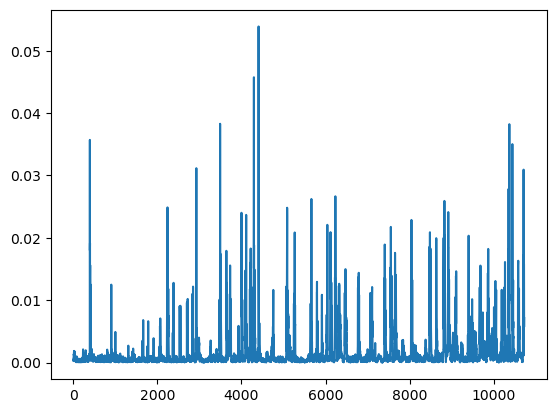

In [ ]:
pupil = raw_data.get_column("pupil_r_thresholded").to_numpy()
timestamp = raw_data.get_column("timestamp").to_numpy()

pupil_diff = np.diff(pupil)
timestamp_diff = np.diff(timestamp)

rates = np.abs(pupil_diff / timestamp_diff)
rates

d_prime = np.maximum(rates[:-1], rates[1:])
d_prime

plt.plot(d_prime)
d_prime

In [ ]:
pupil_size = raw_data.get_column("pupil_r_thresholded").to_numpy()
timestamps = raw_data.get_column("timestamp").to_numpy()

# Step 1: Calculate dilation speed
dilation_speed = np.abs(np.diff(pupil_size) / np.diff(timestamps))
dilation_speed = np.maximum.reduceat(dilation_speed, range(0, len(dilation_speed), 2))

# Step 2: Identify dilation speed outliers
mad = np.median(np.abs(dilation_speed - np.median(dilation_speed)))
threshold = np.median(dilation_speed) + 3 * mad  # Adjust the multiplier as needed
valid_samples = dilation_speed < threshold

ic(dilation_speed, threshold, mad, valid_samples)

ic| dilation_speed: array([0.00045223, 0.00045536, 0.00032144, ..., 0.00985491, 0.00713178,
                           0.00636044])
    threshold: np.float64(0.0018344465263589451)
    mad: np.float64(0.0003884835036514806)
    valid_samples: array([ True,  True,  True, ..., False, False, False])


(array([0.00045223, 0.00045536, 0.00032144, ..., 0.00985491, 0.00713178,
        0.00636044]),
 np.float64(0.0018344465263589451),
 np.float64(0.0003884835036514806),
 array([ True,  True,  True, ..., False, False, False]))

In [ ]:
def calculate_d_prime(d, t):
    """
    Vectorized calculation of dilation speed series d'.

    Parameters:
    d (list or array): Data points array.
    t (list or array): Time points array.

    Returns:
    numpy.ndarray: The dilation speed series d'.
    """
    d = np.array(d)
    t = np.array(t)

    # Calculate differences in d and t
    d_diff = np.diff(d)  # d[i+1] - d[i]
    t_diff = np.diff(t)  # t[i+1] - t[i]

    # Avoid division by zero and calculate rates of change
    rates = np.abs(d_diff / t_diff)

    # Calculate max of rates[i-1] and rates[i] for each valid i
    d_prime = np.maximum(rates[:-1], rates[1:])

    return d_prime


def calculate_mad_and_threshold(d_prime, n):
    """
    Calculate the Median Absolute Deviation (MAD) and the threshold for outlier detection.

    Parameters:
    d_prime (numpy.ndarray): The dilation speed series d'.
    n (float): The constant multiplier for MAD.

    Returns:
    tuple: A tuple containing the MAD and the threshold.
    """
    mad = np.median(np.abs(d_prime - np.median(d_prime)))
    threshold = np.median(d_prime) + n * mad

    return mad, threshold


# # Example data
d = pupil_size
t = timestamps
n = 16  # as in code dilationSpeedFilter_MadMultiplier


# Calculate d' (dilation speed series)
d_prime = calculate_d_prime(d, t)

# Calculate MAD and threshold
mad, threshold = calculate_mad_and_threshold(d_prime, n)

d_prime, mad, threshold

(array([0.00045223, 0.00045536, 0.00045536, ..., 0.00570251, 0.00713178,
        0.00713178]),
 np.float64(0.00039479518391534343),
 np.float64(0.00699055987281966))

In [ ]:
plt.plot(d_prime)
# x in log
plt.yscale("log")
# add horizontal line for threshold
plt.axhline(threshold, color="red", linestyle="--")

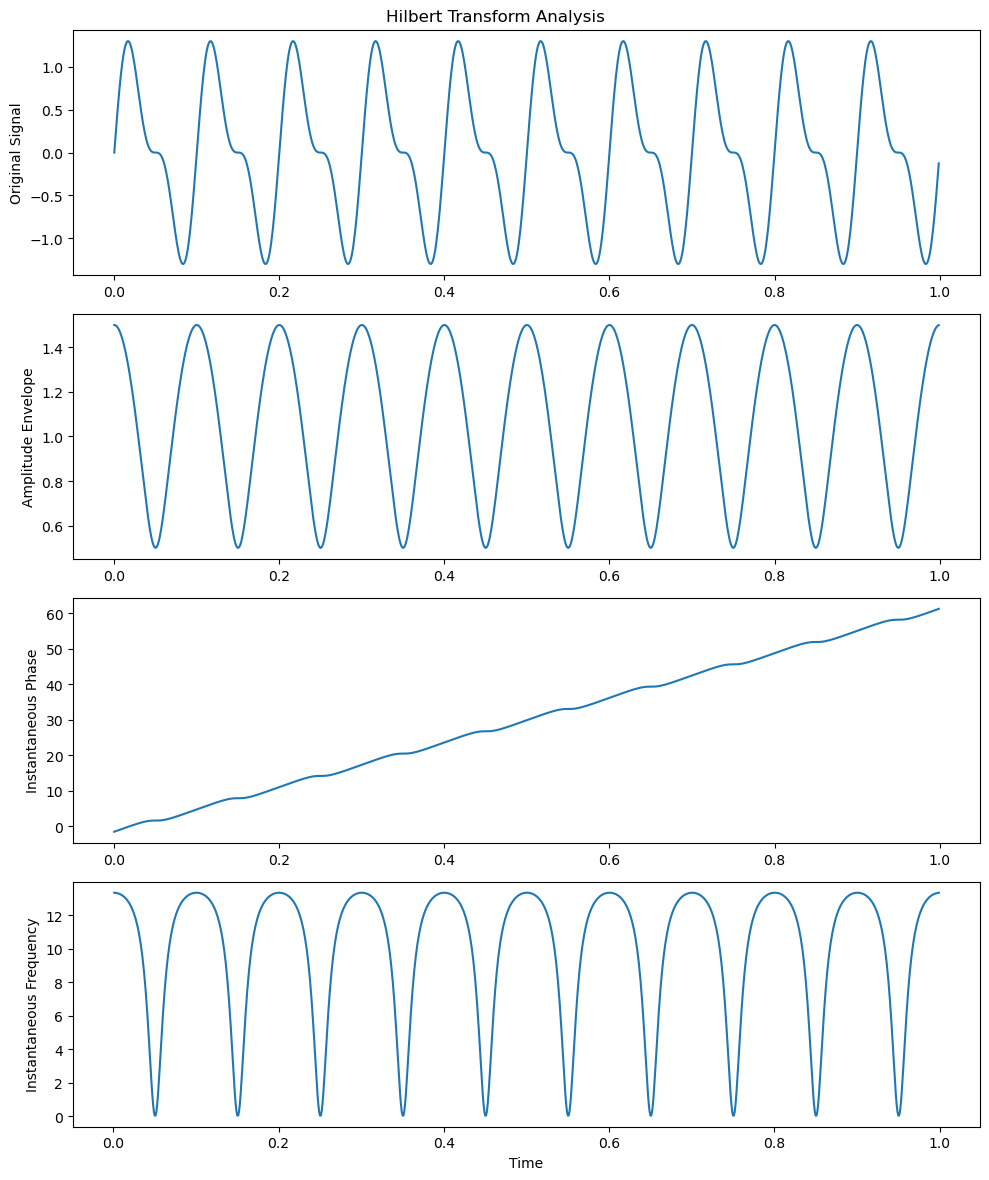

In [20]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

def hilbert_transform(signal):
    """
    Compute the Hilbert transform of a given signal.
    
    Parameters:
    signal (array-like): Input signal
    
    Returns:
    analytic_signal (complex array): The analytic signal (original + imaginary)
    amplitude_envelope (array): The amplitude envelope of the signal
    instantaneous_phase (array): The instantaneous phase of the signal
    instantaneous_frequency (array): The instantaneous frequency of the signal
    """
    
    # Compute the analytic signal (using the Hilbert transform)
    analytic_signal = hilbert(signal)
    
    # Compute the amplitude envelope
    amplitude_envelope = np.abs(analytic_signal)
    
    # Compute the instantaneous phase
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    
    # Compute the instantaneous frequency
    instantaneous_frequency = np.diff(instantaneous_phase) / (2.0*np.pi) * fs
    
    return analytic_signal, amplitude_envelope, instantaneous_phase, instantaneous_frequency

# Example usage
if __name__ == "__main__":
    # Generate a sample signal
    fs = 1000  # Sampling frequency
    t = np.linspace(0, 1, fs, endpoint=False)
    signal = np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 20 * t)
    
    # Compute Hilbert transform
    analytic_signal, amplitude_envelope, inst_phase, inst_freq = hilbert_transform(signal)
    
    # Plot results
    fig, axs = plt.subplots(4, 1, figsize=(10, 12))
    fig.suptitle('Hilbert Transform Analysis')
    
    axs[0].plot(t, signal)
    axs[0].set_ylabel('Original Signal')
    
    axs[1].plot(t, amplitude_envelope)
    axs[1].set_ylabel('Amplitude Envelope')
    
    axs[2].plot(t, inst_phase)
    axs[2].set_ylabel('Instantaneous Phase')
    
    axs[3].plot(t[1:], inst_freq)
    axs[3].set_ylabel('Instantaneous Frequency')
    axs[3].set_xlabel('Time')
    
    plt.tight_layout()
    plt.show()